# Titanic: Feature Engineering

### Import thư viện

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid", font_scale=1.1)

exps_dir = "../../data"
data_path = "../exps/data"

### Đọc dữ liệu 

In [2]:
# Đọc dữ liệu gốc
df_train_org = pd.read_csv(f"{exps_dir}/train.csv")
df_test_org = pd.read_csv(f"{exps_dir}/test.csv")

# Đọc dữ liệu đã preprocessing
df_train_pre = pd.read_excel(f"{data_path}/train.xlsx")
df_valid_pre  = pd.read_excel(f"{data_path}/valid.xlsx")
df_test_pre  = pd.read_excel(f"{data_path}/test.xlsx")

# Đọc dữ liệu index 
idx = np.load(f'{data_path}/idx.npz')
id_train = idx['id_train']
id_valid = idx['id_valid']

# Lấy train valid trên tập gốc
df_train_raw = df_train_org.iloc[id_train].copy()
df_valid_raw = df_train_org.iloc[id_valid].copy()

print("Kích thước dữ liệu:")
print("Train:", df_train_org.shape)
print("Test:", df_test_org.shape)

df_train_org.head()

Kích thước dữ liệu:
Train: (891, 12)
Test: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Xử lý giá trị thiếu cho cột Cabin

In [3]:
print(f"- Train Cabin missing: {df_train_raw['Cabin'].isnull().sum()}")
print(f"- Train Cabin missing: {df_valid_raw['Cabin'].isnull().sum()}")
print(f"- Test  Cabin missing: {df_test_org['Cabin'].isnull().sum()}")

- Train Cabin missing: 553
- Train Cabin missing: 134
- Test  Cabin missing: 327


In [4]:
for df in [df_train_raw, df_valid_raw, df_test_org]:
    df["Cabin"] = df["Cabin"].fillna("U")

In [14]:
print("Train Cabin missing after fill:")
print(df_train_raw["Cabin"].isnull().sum())

print("Valid Cabin missing after fill:")
print(df_valid_raw["Cabin"].isnull().sum())

print("\nTest Cabin missing after fill:")
print(df_test_org["Cabin"].isnull().sum())

Train Cabin missing after fill:
0
Valid Cabin missing after fill:
0

Test Cabin missing after fill:
0


### Đặc trưng Cabin

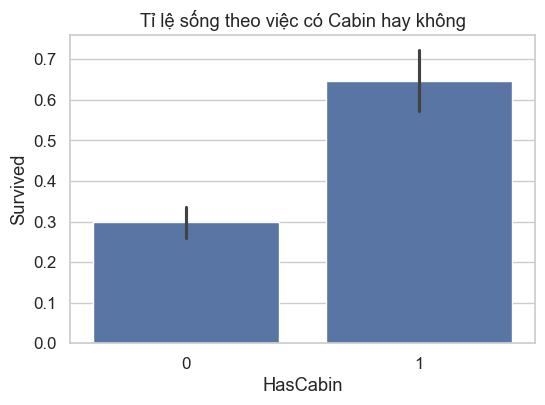

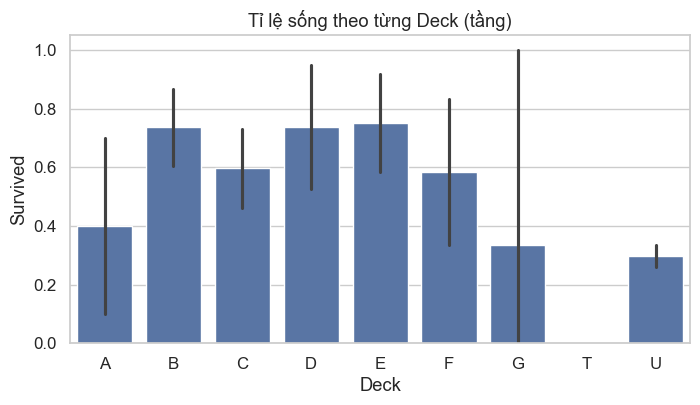

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hàm xử lý Cabin
def process_cabin(df):
    df["Cabin"] = df["Cabin"].fillna("U")
    df["HasCabin"] = df["Cabin"].apply(lambda x: 0 if x == "U" else 1)
    df["Deck"] = df["Cabin"].apply(lambda x: x[0] if x != "U" else "U")
    return df

# Đặc trưng Cabin
df_train_raw = process_cabin(df_train_raw)
df_valid_raw = process_cabin(df_valid_raw)
df_test_org = process_cabin(df_test_org)

df_train_pre["HasCabin"] = df_train_raw["HasCabin"].values
df_valid_pre["HasCabin"] = df_valid_raw["HasCabin"].values
df_test_pre["HasCabin"] = df_test_org["HasCabin"].values

df_train_pre["Deck"] = df_train_raw["Deck"].values
df_valid_pre["Deck"] = df_valid_raw["Deck"].values
df_test_pre["Deck"] = df_test_org["Deck"].values


# Vẽ biểu đồ tỉ lệ sống theo HasCabin
plt.figure(figsize=(6,4))
sns.barplot(x="HasCabin", y="Survived", data=df_train_raw)
plt.title("Tỉ lệ sống theo việc có Cabin hay không")
plt.show()

# Biểu đồ tỉ lệ sống theo Deck
plt.figure(figsize=(8,4))
sns.barplot(x="Deck", y="Survived", data=df_train_raw, order=sorted(df_train_raw["Deck"].unique()))
plt.title("Tỉ lệ sống theo từng Deck (tầng)")
plt.show()

**Nhận xét**
- Hành khách có Cabin riêng thường thuộc tầng lớp cao → tỉ lệ sống cao hơn rõ rệt.

- Một số Deck như B, C, D có tỉ lệ sống cao hơn do gần thuyền cứu sinh.

### Trích danh xưng từ Name (Title)

Danh xưng sau khi chuẩn hóa:
Title
Mr        419
Miss      146
Mrs        97
Master     33
Rare       17
Name: count, dtype: int64


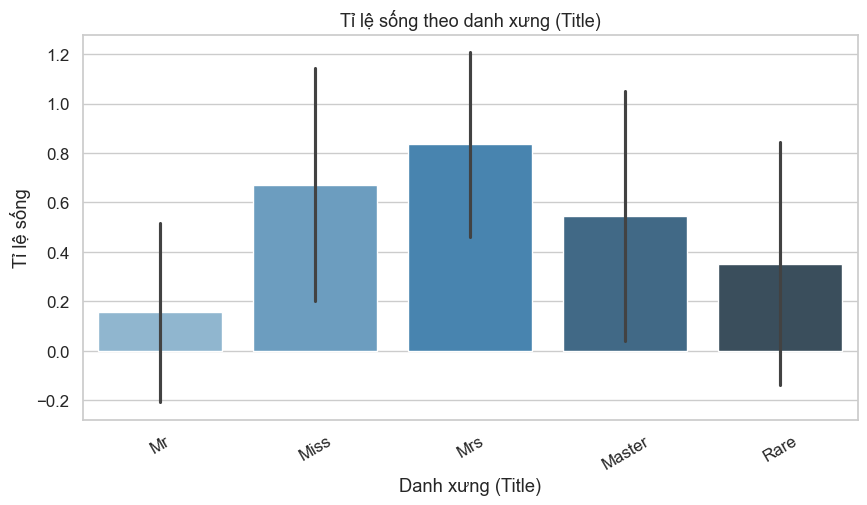

In [7]:
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Hàm tách danh xưng từ Name
def extract_title(name):
    match = re.search(r",\s*([A-Za-z\s]+)\.", name)
    return match.group(1).strip() if match else "Unknown"

# Hàm xử lý danh xưng
def process_title(df):
    df["Title"] = df["Name"].apply(extract_title)
    rare_titles = [
        "Lady", "Countess", "the Countess", "Capt", "Col", "Don", "Dr",
        "Major", "Rev", "Sir", "Jonkheer", "Dona"
    ]
    df["Title"] = df["Title"].replace(rare_titles, "Rare")
    df["Title"] = df["Title"].replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})
    return df

# Áp dụng cho cả train và test
df_train_raw = process_title(df_train_raw)
df_valid_raw = process_title(df_valid_raw)
df_test_org = process_title(df_test_org)

df_train_pre["Title"] = df_train_raw["Title"].values
df_valid_pre["Title"] = df_valid_raw["Title"].values
df_test_pre["Title"] = df_test_org["Title"].values

# Kiểm tra lại danh xưng
print("Danh xưng sau khi chuẩn hóa:")
print(df_train_raw["Title"].value_counts())

# Biểu đồ tỉ lệ sống theo danh xưng
plt.figure(figsize=(10, 5))
sns.barplot(
    x="Title",
    y="Survived",
    data=df_train_raw,
    order=df_train_raw["Title"].value_counts().index,
    errorbar="sd",
    palette="Blues_d"
)
plt.title("Tỉ lệ sống theo danh xưng (Title)", fontsize=13)
plt.xlabel("Danh xưng (Title)")
plt.ylabel("Tỉ lệ sống")
plt.xticks(rotation=30)
plt.show()

**Nhận xét**
- Các danh xưng ‘Mrs’, ‘Miss’ có tỷ lệ sống cao, phản ánh quy tắc ưu tiên phụ nữ và trẻ em.

- ‘Master’ (thường là trẻ em nam) cũng có tỷ lệ sống khá tốt.

- ‘Mr’ có tỷ lệ sống thấp nhất, đa số là nam trưởng thành.

- Các danh xưng hiếm (“Rare”) thường thuộc tầng lớp sĩ quan hoặc quý tộc nam → tỷ lệ sống thấp hơn.

### Đặc trưng Family

<Figure size 800x500 with 0 Axes>

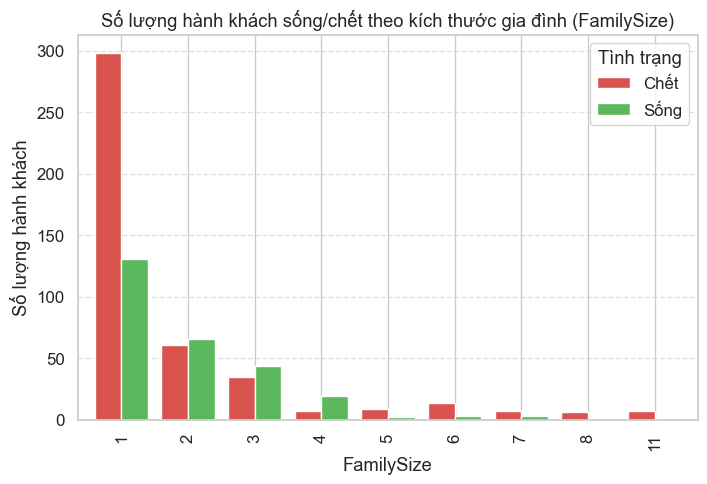

In [8]:
for df in [df_train_raw,df_valid_raw, df_test_org]:
    # FamilySize = Số người đi cùng (anh chị em, cha mẹ) + bản thân
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    
    # IsAlone = đi một mình
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

df_train_pre["FamilySize"] = df_train_raw["FamilySize"].values
df_valid_pre["FamilySize"] = df_valid_raw["FamilySize"].values
df_test_pre["FamilySize"]  = df_test_org["FamilySize"].values

df_train_pre["IsAlone"] = df_train_raw["IsAlone"].values
df_valid_pre["IsAlone"] = df_valid_raw["IsAlone"].values
df_test_pre["IsAlone"]  = df_test_org["IsAlone"].values

plt.figure(figsize=(8,5))

family_counts = df_train_raw.groupby(["FamilySize", "Survived"]).size().unstack(fill_value=0)

# Vẽ biểu đồ 2 cột
family_counts.plot(
    kind="bar",
    figsize=(8,5),
    color=["#d9534f", "#5cb85c"],
    width=0.8
)

plt.title("Số lượng hành khách sống/chết theo kích thước gia đình (FamilySize)")
plt.xlabel("FamilySize")
plt.ylabel("Số lượng hành khách")
plt.legend(["Chết", "Sống"], title="Tình trạng")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

**Nhận xét**
- FamilySize = 1 (đi một mình) có tỉ lệ sống rất thấp.

- FamilySize từ 2–4 có tỉ lệ sống cao nhất, vì thường đi cùng người thân → được hỗ trợ khi gặp nạn.

- FamilySize lớn hơn 4 có tỉ lệ sống giảm, do khó di chuyển và dễ bị tách đoàn trong lúc di tản.

### Đặc trưng nhóm tuổi (AgeBin)

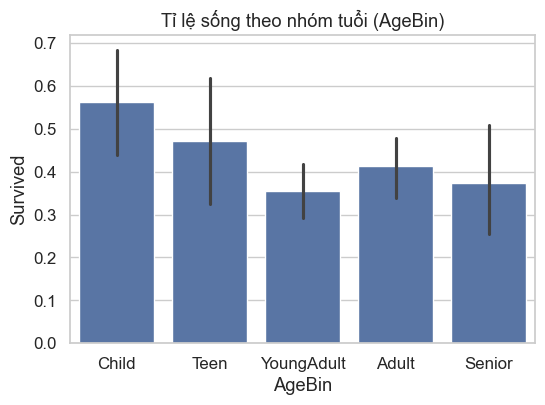

In [9]:
bins = [0, 12, 18, 30, 50, 80]
labels = ["Child", "Teen", "YoungAdult", "Adult", "Senior"]

for df in [df_train_raw, df_valid_raw, df_test_org]:
    df["AgeBin"] = pd.cut(df["Age"], bins=bins, labels=labels, right=False)

df_train_pre["AgeBin"] = df_train_raw["AgeBin"].values
df_valid_pre["AgeBin"] = df_valid_raw["AgeBin"].values
df_test_pre["AgeBin"]  = df_test_org["AgeBin"].values

plt.figure(figsize=(6,4))
sns.barplot(x="AgeBin", y="Survived", data=df_train_raw, order=labels)
plt.title("Tỉ lệ sống theo nhóm tuổi (AgeBin)")
plt.show()

**Nhận xét**
- Trẻ em (Child) có tỉ lệ sống sót cao nhất, cho thấy việc ưu tiên trẻ em trong cứu hộ.
- Người lớn trong độ tuổi từ 30-50 ("Adult") có tỉ lệ sống thấp nhất.

### Nhóm giá vé (FareBin)

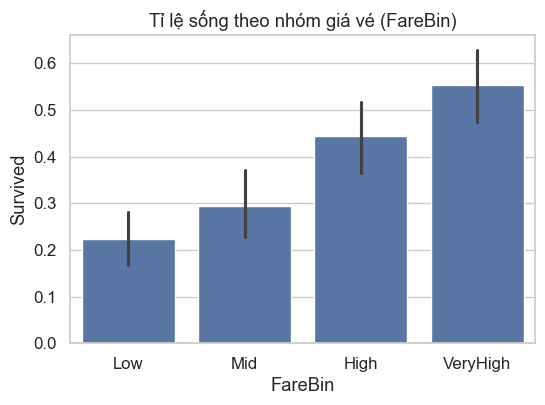

In [10]:
labels = ["Low", "Mid", "High", "VeryHigh"]

fare_bins, fare_labels = pd.qcut(df_train_raw["Fare"], 4, labels=labels, retbins=True)

df_train_raw["FareBin"] = fare_bins
df_valid_raw["FareBin"] = pd.cut(df_valid_raw["Fare"], bins=fare_labels, labels=labels, include_lowest=True)
df_test_org["FareBin"]  = pd.cut(df_test_org["Fare"], bins=fare_labels, labels=labels, include_lowest=True)

df_train_pre["FareBin"] = df_train_raw["FareBin"].values
df_valid_pre["FareBin"] = df_valid_raw["FareBin"].values
df_test_pre["FareBin"]  = df_test_org["FareBin"].values

plt.figure(figsize=(6,4))
sns.barplot(x="FareBin", y="Survived", data=df_train_raw, order=["Low", "Mid", "High", "VeryHigh"])
plt.title("Tỉ lệ sống theo nhóm giá vé (FareBin)")
plt.show()

**Nhận xét**
- Giá vé càng cao thì tỉ lệ sống sót càng cao, phản ánh rõ mối liên hệ với hạng vé (Pclass).

In [11]:
df_train_pre.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,HasCabin,Deck,Title,FamilySize,IsAlone,AgeBin,FareBin
0,0,1,1,0.566474,0,0,0.055628,56,2,1,C,Mr,1,1,Adult,High
1,0,2,1,0.283740,0,0,0.025374,147,2,0,U,Mr,1,1,YoungAdult,Mid
2,0,3,1,0.396833,0,0,0.015469,147,2,0,U,Mr,1,1,Adult,Low
3,0,3,1,0.321438,1,0,0.015330,147,2,0,U,Mr,2,0,YoungAdult,Low
4,0,3,0,0.070118,4,2,0.061045,147,2,0,U,Miss,7,0,Child,VeryHigh
5,0,1,1,0.296306,0,1,0.483128,36,0,1,B,Mr,2,0,YoungAdult,VeryHigh
6,0,1,1,0.560191,0,0,0.051822,26,2,1,B,Rare,1,1,Adult,High
7,0,2,1,0.359135,1,0,0.054107,147,0,0,U,Mr,2,0,YoungAdult,High
8,0,3,1,0.346569,0,0,0.015412,147,2,0,U,Mr,1,1,NaN,Low
9,1,1,1,0.346569,0,0,0.069291,71,2,1,C,Mr,1,1,NaN,VeryHigh


In [12]:
# Lưu dữ liệu sau khi feature engineering để train mô hình
import os

save_dir = "../exps/data"
os.makedirs(save_dir, exist_ok=True)

# Lưu lại dữ liệu train & test sau khi thêm đặc trưng mới
df_train_pre.to_excel(f"{save_dir}/train_feat.xlsx", index=False)
df_valid_pre.to_excel(f"{save_dir}/valid_feat.xlsx", index=False)
df_test_pre.to_excel(f"{save_dir}/test_feat.xlsx", index=False)

print("Đã lưu dữ liệu sau khi Feature Engineering:")
print(f"- {save_dir}/train_feat.xlsx")
print(f"- {save_dir}/valid_feat.xlsx")
print(f"- {save_dir}/test_feat.xlsx")

Đã lưu dữ liệu sau khi Feature Engineering:
- ../exps/data/train_feat.xlsx
- ../exps/data/valid_feat.xlsx
- ../exps/data/test_feat.xlsx
